In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat, u_darrays
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
ar = xr.open_dataarray(cnst.GRIDSAT + 'aggs/WAbox_meanT-50_hov_5000km2.nc')

In [5]:
ar

<xarray.DataArray (year: 35, month: 12, lat: 221)>
array([[[       nan,        nan, ...,        nan,        nan],
        [-57.061832, -57.01714 , ...,        nan,        nan],
        ...,
        [-58.50758 , -58.51719 , ...,        nan,        nan],
        [-57.789047, -58.009644, ...,        nan,        nan]],

       [[-59.189384, -60.21375 , ...,        nan,        nan],
        [-60.4876  , -60.945606, ...,        nan,        nan],
        ...,
        [-63.016857, -62.818012, ...,        nan,        nan],
        [-60.663425, -60.848774, ..., -53.744995, -54.04999 ]],

       ...,

       [[-57.324276, -57.57629 , ..., -57.566654, -56.698845],
        [-58.049515, -58.13839 , ...,        nan,        nan],
        ...,
        [-63.462494, -63.046154, ...,        nan,        nan],
        [-61.002815, -60.84319 , ...,        nan, -53.50499 ]],

       [[-64.139626, -64.160706, ...,        nan,        nan],
        [-63.468567, -63.528774, ...,        nan,        nan],
        .

In [6]:
mean = ar.mean('year')

In [7]:
mean

<xarray.DataArray (month: 12, lat: 221)>
array([[-60.817497, -60.863388, -61.234497, ..., -53.233486, -54.513557,
        -53.977608],
       [-61.308334, -61.547287, -61.949734, ..., -52.81835 , -53.563488,
        -54.075844],
       [-63.469753, -63.651485, -64.06175 , ..., -54.133923, -53.983658,
        -51.968384],
       ...,
       [-59.12421 , -59.30329 , -59.518494, ..., -58.575497, -57.65965 ,
        -57.740448],
       [-60.256535, -60.22689 , -60.35731 , ..., -53.787277, -54.017887,
        -53.27243 ],
       [-59.95628 , -59.981396, -60.241623, ..., -53.566105, -53.78535 ,
        -53.496246]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 4.550003 4.6200027 4.6900024 ... 19.879997 19.949997

In [8]:
def calc_trend(mean_years, method='mk', sig=False):
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['lat', 'month'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0
            
    return dtrend

In [9]:
trend=calc_trend(ar)

Entering trend calc


/home/ck/pythonWorkspace/proj_CEH/utils/u_mann_kendall.py:59: RuntimeWarning: invalid value encountered in less_equal
  tmp[np.where(np.fabs(tmp) <= eps)] = 0.
/home/ck/pythonWorkspace/proj_CEH/utils/u_mann_kendall.py:73: RuntimeWarning: invalid value encountered in less
  idx =  np.where(np.fabs(x - ties[k]) < eps)[0]


In [10]:
trend['slope'].values = trend['slope'].values*10

In [11]:
trend['slope'].values[trend['pval'].values>0.05] = 0

In [55]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, l1, l2, nb,title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None,cmap='Blues'):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    #mapp = ax.contourf(lon, lat, data, **kwargs)  # this is the actual plot
    nb_lev = nb
    cmapp = uplot.discrete_cmap(nb_lev, base_cmap=cmap)

    mapp = ax.pcolormesh(np.arange(0.5,13,1), lat,data
                          ,cmap=cmapp, vmin=l1, vmax=l2)

    cbar = plt.colorbar(mapp, ticks=np.linspace(l1,l2,nb_lev+1))
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.pcolormesh(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
#     ax.coastlines()   ## adds coastlines
#     # Gridlines
#     xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
#     xl.xlabels_top = False   ## labels off
#     xl.ylabels_right = False
#     plt.title(title)
#     # Countries
#     ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
   # cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

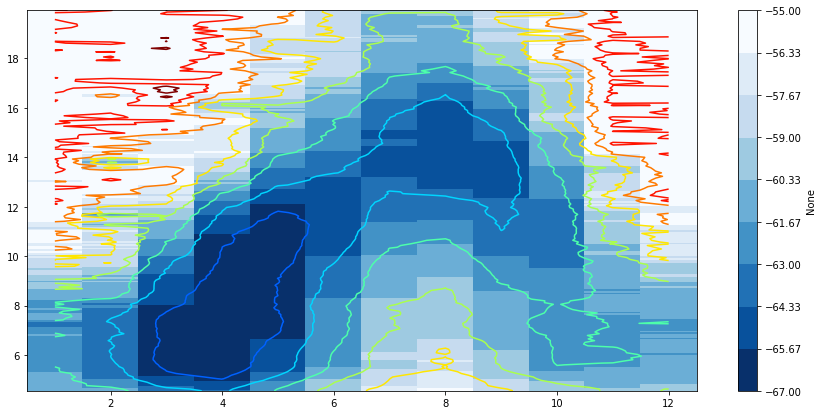

In [60]:
contour = {'x' : mean.month.values, 'y': mean.lat.values, 'data': mean.values.T, 'levels': np.arange(-70,-50,2), 'cmap':'jet'}
draw_map(mean.values.T, mean.month, mean.lat, -55, -67, 9, cmap='Blues_r', contour=contour)

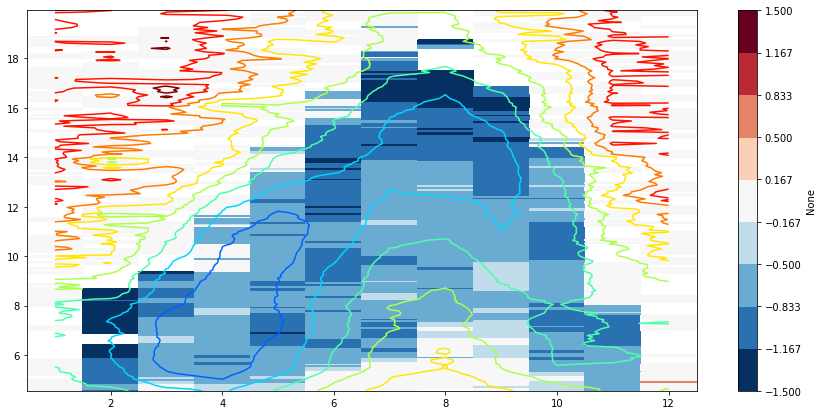

In [59]:
contour = {'x' : mean.month.values, 'y': mean.lat.values, 'data': mean.values.T, 'levels': np.arange(-70,-50,2), 'cmap':'jet'}
draw_map(trend['slope'], trend.month, trend.lat, -1.5, 1.5, 9, cmap='RdBu_r', contour=contour)

In [103]:
ar = xr.open_dataarray(cnst.GRIDSAT + 'aggs/SAbox_meanT-50_hov_5000km2.nc')

In [104]:
trend=calc_trend(ar)

Entering trend calc


/home/ck/pythonWorkspace/proj_CEH/utils/u_mann_kendall.py:59: RuntimeWarning: invalid value encountered in less_equal
  tmp[np.where(np.fabs(tmp) <= eps)] = 0.
/home/ck/pythonWorkspace/proj_CEH/utils/u_mann_kendall.py:73: RuntimeWarning: invalid value encountered in less
  idx =  np.where(np.fabs(x - ties[k]) < eps)[0]


In [105]:
trend['slope'].values = trend['slope'].values*10
#trend['slope'].values[trend['pval'].values>0.05] = 0

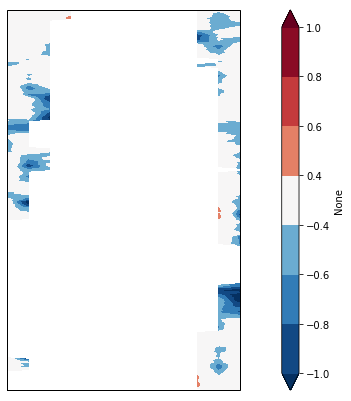

In [106]:
contour = {'x' : mean.month.values, 'y': mean.lat.values, 'data': mean.values.T, 'levels': np.arange(-70,-50,2), 'cmap':'jet'}
draw_map(trend['slope'], trend.month, trend.lat, cmap='RdBu_r', levels=[-1,-0.8,-0.6,-0.4,0.4,0.6,0.8,1], extend='both')